[Illustration#1: First Order DLM](#first-order)


## Illustration#1: First Order DLM <a id="first-order"></a> 

- state equation: $x_t = x_{t-1}+w_t$
- observation equation: $Y_t = x_t + v_t$

### Grounding Truth

**Simulate the state and observation equations for 1st order DLM**

In [7]:
library(dlm)

In [1]:
W = 0.5 
V = 1 

n = 100
x0 = 0 # state 0 

w = rnorm(n, 0, sqrt(W)) # simulate error 
v = rnorm(n, 0, sqrt(V)) # simulated error 

x = y = rep(0, n) # empty list store simulated x and simulated y 

In [2]:
x[1] = x0 + w[1] # initial state equation 
y[1] = x[1] + v[1] # initial observation equation 

In [3]:
for (t in 2:n){
    x[t] = x[t-1] + w[t] # update state equation with random draw
    y[t] = x[t] + v[t] # update obs equation with random draw plus new state val
}

In [4]:
y1 = y 
x1 = x

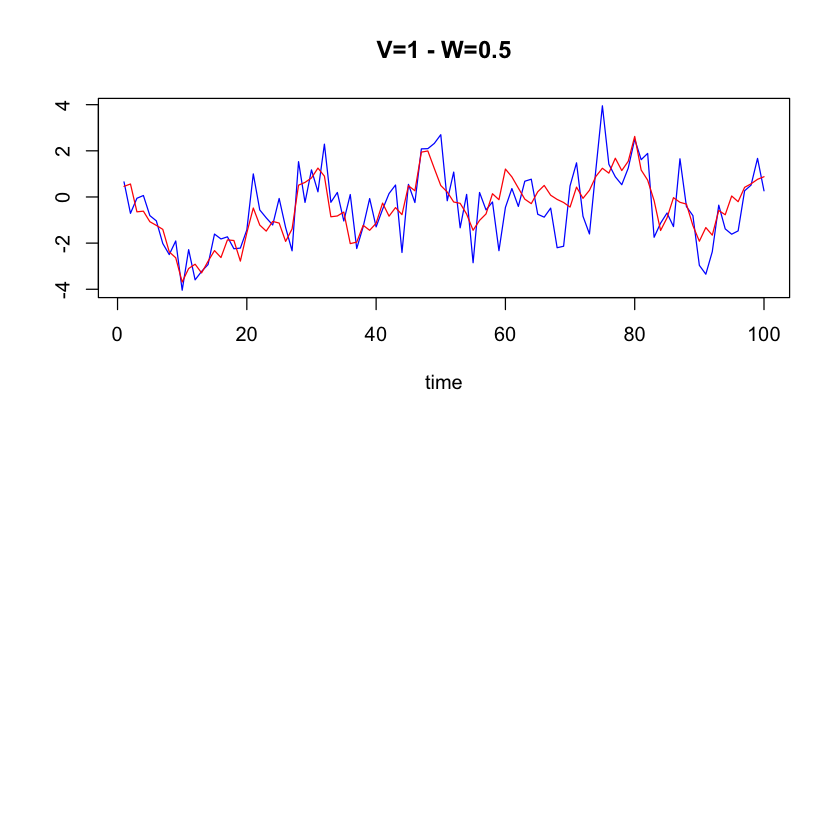

In [5]:
par(mfrow=c(2, 1))
plot(y1, type="l", xlab="time", col="blue", ylab="") #observed
lines(x1, col="red") #state var 
title(paste("V=",V," - W=",W,sep=""))

### Fit for 1st Order DLM

**General Form**
- State equation: $\theta_t = G_t \theta_{t-1}+w_t , w_t \sim N(0, W_t)$, $\beta_t \sim 2 \times 1$
- obs equation: $Y_t = F_t'\theta_t + v_t , v_t \sim N(0, V_t)$ ,$v_{it} \sim N(0, V_t)$
- prior: $\beta_1 \sim N(a_1, R_1)$

**First Order Polynomial Model: Example of 1st Order DLM with G=1, F=1**
$$\begin{equation*}
\left\{
\begin{aligned}
y_t &= \theta_t + v_t, & v_t &\sim \mathcal{N}(0, V) \\
\theta_t &= \theta_{t-1} + w_t, & w_t &\sim \mathcal{N}(0, W)
\end{aligned}
\right.
\end{equation*}
$$
- Assumptions:
  - $W = 0.5$
  - $V = 1 $

- **Posterior Mean and Var**
  - $\hat{\theta_t} = \hat{\theta}_{t-1} + R_t  (V_t +  R_t )^{-1}e_t$
  - $\Sigma_t = R_t - R_t(V_t+R_t)^{-1}R_t$



```R
# use dlm package to define a random walk plus noise model with V=0.8, W=0.1
dlm(FF=1, V=0.8, GG=1, W=0.1, m0=0, C0=100)
# alternatively 
dlmModPoly(order=1, dV=0.8, dW=0.1, C0=100)
```

### Forward Filter

#### Way 1

In [11]:
y = y1 # simulated value of y_t 

# assume W and V are known 
W = 0.5 
V = 1 

# prior at t=1 
a1 = 0
R1 = 100

m = rep(0, n) #store posterior mean 
C = rep(0, n) # store posterior variance 

B = rep(0, n-1)
H = rep(0, n-1)

In [116]:
# t=1 x_1 ~ N(a_1, R_1)
a = a1 # prior mean
R = R1 # prior var

# pred of y1 mean: y_t = \theta_t + v_t, y1 = \theta_1 + v_1 
f = a
# pred of y1 var 
Q = R+V  # var(y1) = var(\theta_1) = R1 + V 

# Kalman Filter
A = R/Q # var(theta) / var(y) 

# posterier mean at t=1 after observing y1: prior mean + Kalman * (error)
m[1] = a + A * (y[1] - f) 

# posterior variance at t-1 aftering observing y1: R - R(V+R)^{-1}R 
C[1] = R - Q*A^2

In [117]:
for (t in 2:n){
    # prior mean and var 
    a = m[t-1] # prior mean, G = 1
    R = C[t-1] + W # prior variance
    
    f = a # mean for prediction step 
    Q = R+V # variance for pred 
    
    A = R/Q # Kalman 
    
    m[t] = a + A * (y[t] - f) # kalman eqn for posterior of mean 
    C[t] = R - Q*A^2 # Kalman eqn for posterior var
    
    m1 = m
    C1 = C
}

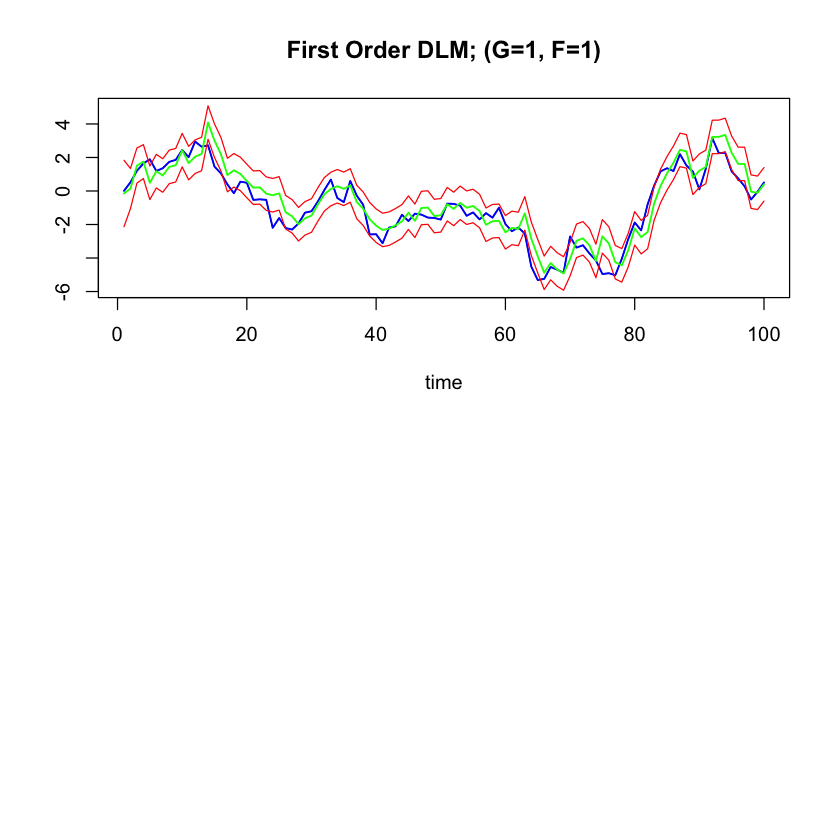

In [146]:
par(mfrow = c(2, 1))
L = m1 - 2*C1
U = m1 + 2*C1
ts.plot(x1, xlab="time", ylab="", ylim=c(min(L), max(U))) 

lines(x1, col='blue', lwd=1.5) 
lines(m1, col='green', lwd=1.5) # poseterior mean for beta_t

lines(L, col='red')
lines(U, col='red')
title("First Order DLM; (G=1, F=1)")

#### Way 2

In [149]:
n = 100
y = y1

a1 = 0
R1 = 100

a = rep(0, n)
R = rep(0, n)
m = rep(0, n)
C = rep(0, n)

mm = rep(0, n-1)
CC = rep(0, n-1)

# time t=1
a[1] = a1
R[1] = R1
f = a[1]
Q = R[1] + V
A = R[1]/Q

m[1] = a[1]+A*(y[1]-f)
C[1] = R[1] - Q*A^2

In [150]:
# forward filtering
for (t in 2:n){
    a[t] = m[t-1]
    R[t] = C[t-1] + W
    f = a[t]
    Q = R[t]+V
    A = R[t]/Q
    m[t] = a[t]+A*(y[t]-f) 
    C[t] = R[t]-Q*A^2
}
# m is exactly the same as before 
mm[n] = m[n] 
CC[n] = C[n]

### Backward Smoothing


#### The Idea

- allows for retrospective construction
- backward transition probabilities
  $$\pi(\theta_t | \theta_{t+1}, y_{1,...T}) \propto \pi(\theta_t | \theta_{t+1}) \pi(\theta_t | y_{1,...T})$$

For $t = n-1, ..., 1$:
$$\beta_{n-1} |y^{n} \sim N(m_t^{n}, C_t^n)$$
where $$m_t^n = m_t + C_t G_{t+1}' R_{t+1}^{-1}(m_{t+1}^n - a_{t+1})$$
$$C_t^n = C_t - C_t G_{t+1}'R_{t+1}^{-1}(R_{t+1}-C_{t+1}^n)R_{t+1}^{-1}G_{t+1}C_t$$

#### Manuelly Code

In [151]:
#backward smoothing
for (t in (n-1):1){
    mm[t] = m[t] + C[t]/R[t+1]*(mm[t+1]-a[t+1]) 
    CC[t] = C[t] - (C[t]^2)/(R[t+1]^2)*(R[t+1]-CC[t+1]) 
}

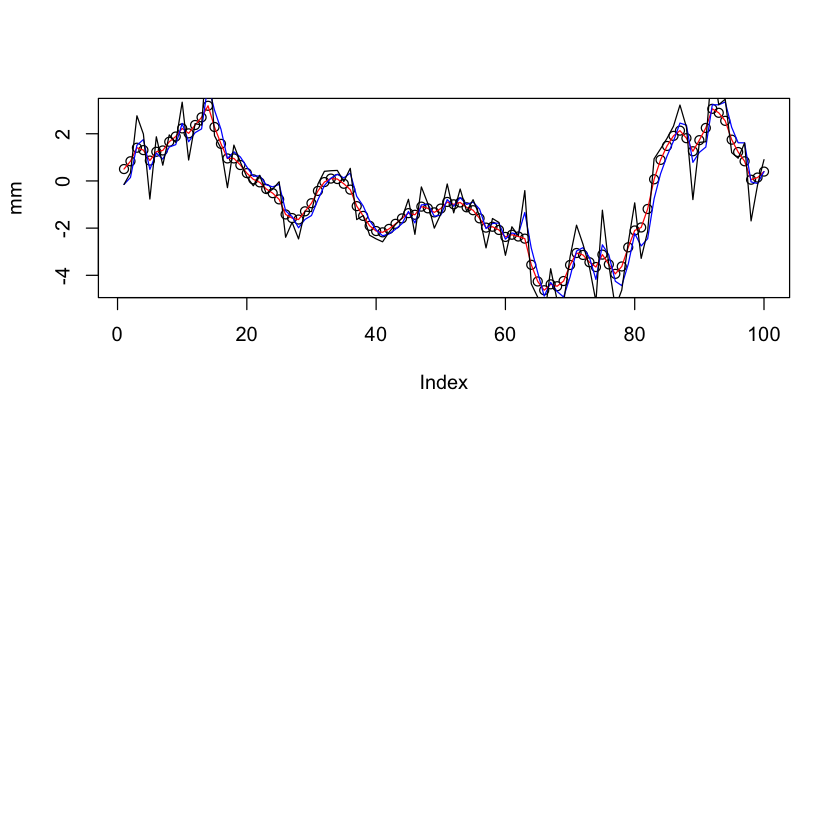

In [153]:
par(mfrow = c(2, 1))

plot(mm)
lines(mm, col='red') #smoothed 
lines(m, col='blue') #filtered
lines(y, col='black') #observed



### Using Maximum Likelihood To Find V and W

In [8]:
# original: V=1, W=0.5 
# ML for Estimating V and W

# define a 1st order DLM with unknown W and V
build <- function(parm){
    dlmModPoly(order=1, dV=exp(parm[1]), dW =exp(parm[2]))
}

# Estimate W  and V using MLE
fit <- dlmMLE(y1, rep(0,2), build) #rep(0, 2) are initial guesses for params

In [9]:
fit$convergence # check if converged, a value of 0 means convergence 
unlist(build(fit$par)[c("V","W")]) # estiamted params are stores in fit$par, 
# then pass back to build to construct the DLM with the estimated variancen

[1] 0

V         W 
1.0075502 0.4110478

In [10]:
simPoly<-dlmModPoly(order=1,dV=1.31,dW=0.38)#Define the model

In [11]:
unlist(simPoly)

m0       C0       FF        V       GG        W 
0.00e+00 1.00e+07 1.00e+00 1.31e+00 1.00e+00 3.80e-01

In [12]:
simFilt <- dlmFilter(y1, simPoly) #run the kalman filter

In [13]:
# str(simFilt, 1)

In [14]:
n <- length(y1)

In [15]:
attach(simFilt)

The following object is masked _by_ .GlobalEnv:

    y




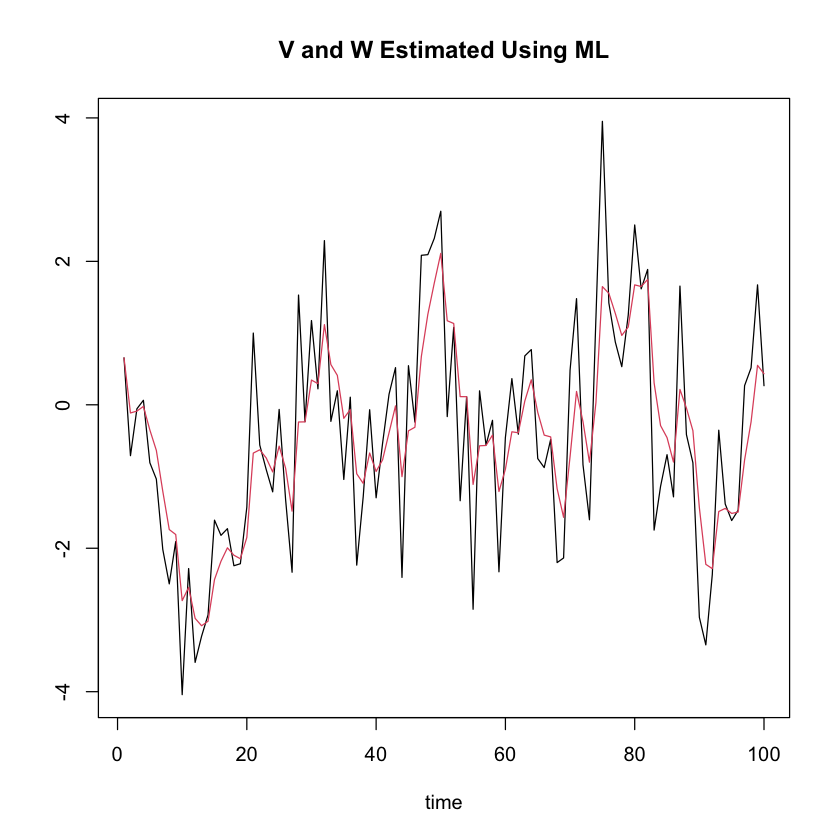

In [16]:
plot(y1,type="l",xlab="time",ylab="") #Plot the observed series
lines(dropFirst(simFilt$m),col=2)#Plot the filter state series (means)
title(paste("V and W Estimated Using ML"))

```R
# std erros for V and W
fit <- dlmMLE(y, rep(0,2), build, hessian=T)
avarLog <- solve(fit$hessian)
avar <- diag(exp(fit$par)) %*% avarLog %*%
diag(exp(fit$par)) # Delta method
sqrt(diag(avar)) # estimated standard errors
```

#### Use Liberary

In [17]:
dlmModPoly(order=1, dV=1.31, dW=0.38) 
# create a state space model, 
# dV: var of obs noise
# dW: var of system noise 

$FF
     [,1]
[1,]    1

$V
     [,1]
[1,] 1.31

$GG
     [,1]
[1,]    1

$W
     [,1]
[1,] 0.38

$m0
[1] 0

$C0
      [,1]
[1,] 1e+07


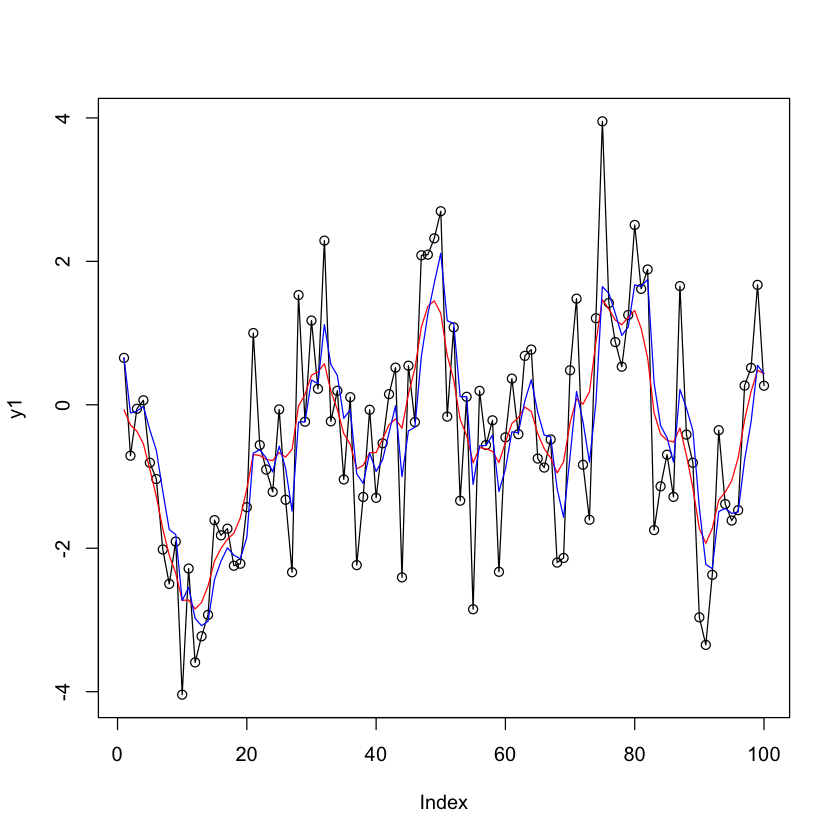

In [18]:
s <- dlmSmooth(y1, dlmModPoly(order=1, dV=1.31, dW=0.38))
plot(y1,type='o') # actual 
lines(dropFirst(s$s), col="red") #smoothed
lines(dropFirst(simFilt$m),col="blue")#Plot the filter state series (means)

## Forcasting

$$f_t = E[y_t|y_{t-1}] = F_t a_t$$
$$Q_t = Var(y_t|y_{t-1} )= F_tR_tF_t' + V_t $$

### Calculate one-step ahead forcast for the simulated 1st Order DLM

Warning message in cbind(y1, dropFirst(simFilt$f)):
“number of rows of result is not a multiple of vector length (arg 2)”


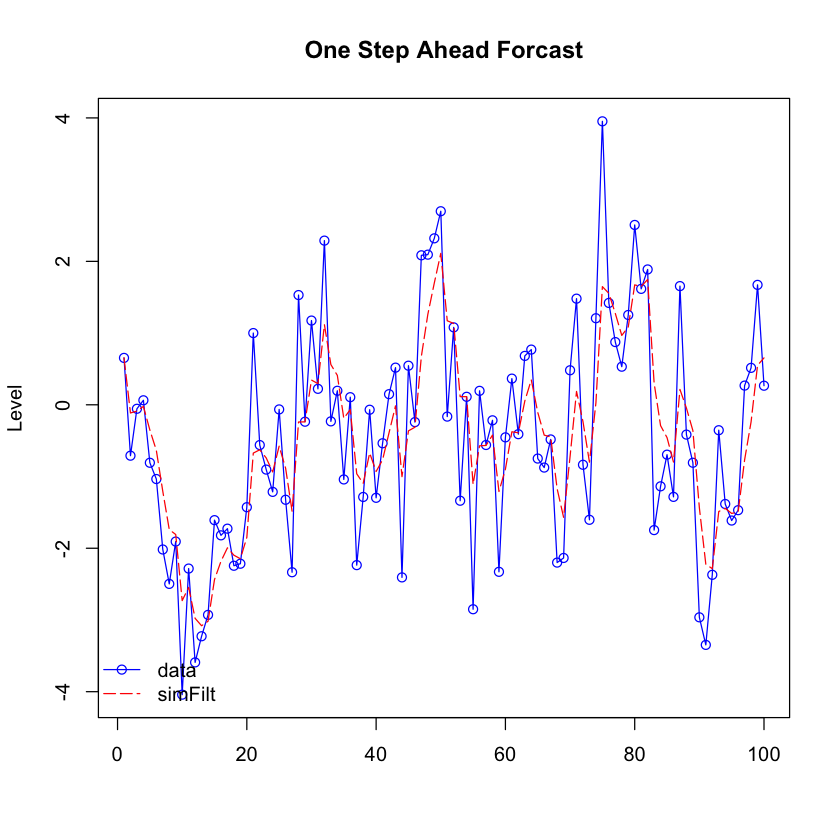

In [28]:
# forecasting
a <- window(cbind(y1, dropFirst(simFilt$f)))
plot(a[, 1], type = 'o', col = "blue",xlab = "", ylab = "Level")
lines(a[, 2], lty = "longdash", col="red")
title("One Step Ahead Forcast")
legend("bottomleft", legend=c("data", c('simFilt')),
      col=c("blue", "red"),
      lty=c("solid", "longdash"),
      pch=c(1, NA), bty="n")